## MLND Capstone Project
### Quora question pairs 

Find out if a pair of questions on Quora website are duplicated. 

In [9]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from os import path
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

### I. Data Exploration

In [10]:
#Read in training data
train_data_raw = pd.read_csv("train.csv")
train_data_raw.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Number of training data: 404290
Ratio of duplicate question pairs: 36.920000 %
Total number of questions: 537933
Number of questions appearing multiple times: 111780


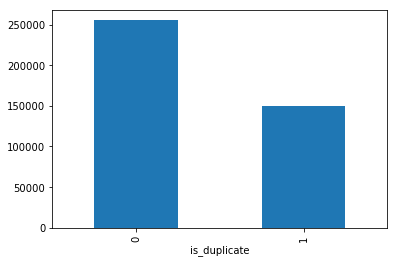

In [7]:
#Look at some statistics of training data
print "Number of training data: %d" %len(train_data_raw)
print "Ratio of duplicate question pairs: %f %%" %round(train_data_raw['is_duplicate'].mean()*100,2)
qids = pd.Series(train_data_raw['qid1'].tolist() + train_data_raw['qid2'].tolist())
print "Total number of questions: %d" %len(np.unique(qids))
print "Number of questions appearing multiple times: %d" %np.sum(qids.value_counts()>1)
train_data_raw.groupby("is_duplicate")['id'].count().plot.bar()

There are 37% duplicate questions in the training set. We also see that there are many identical questions in the data set. 

In [11]:
#Read in test data and look at the first 5 rows
test_data_raw = pd.read_csv("test.csv")
print "Number of testing data: %d" %len(test_data_raw)
test_data_raw.head(5)

Number of testing data: 2345796


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


(-0.5, 1279.5, 979.5, -0.5)

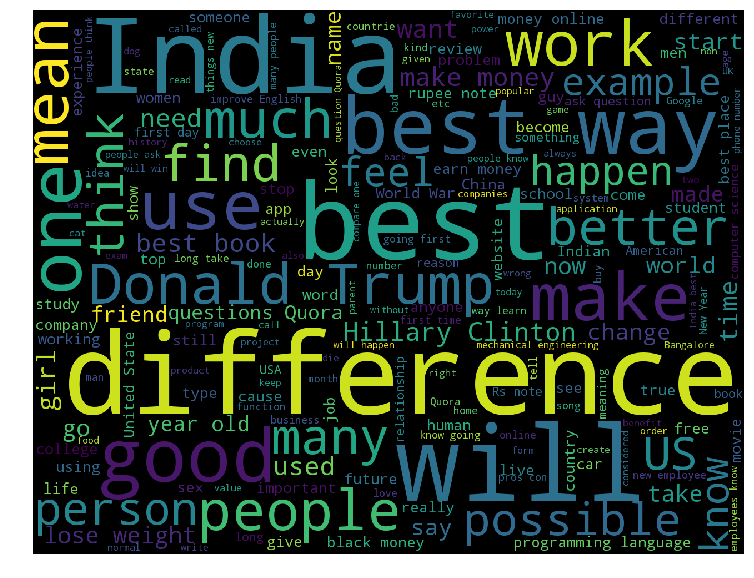

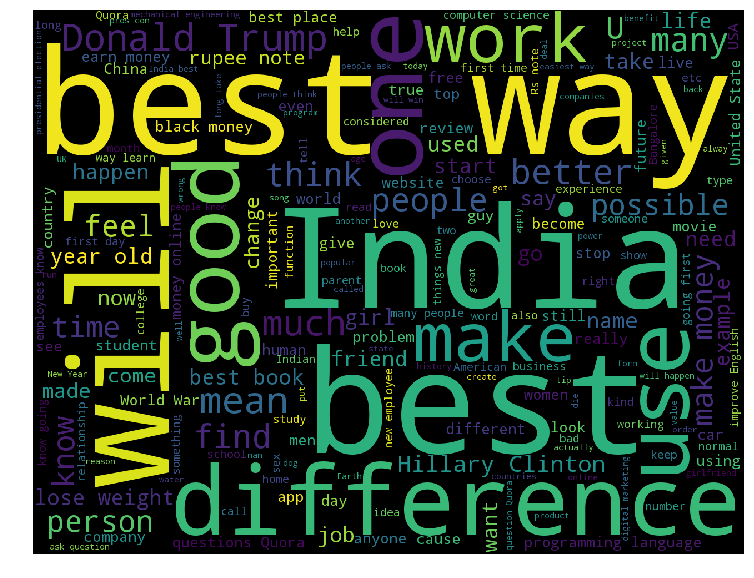

In [6]:
#Check out the most common words in word cloud graph from training data.
cloud1 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question1'].astype(str)))
cloud2 = WordCloud(width=1280, height=980).generate(" ".join(train_data_raw['question2'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud1)
plt.axis('off')
plt.figure(figsize=(15, 10))
plt.imshow(cloud2)
plt.axis('off')

Two word clouds generated from question 1 and question 2 show that there are a few duplicate most common words in them.

### II. Data Processing

First let's write some functions for calculating word share and TFIDF word share.

In [12]:
#Function to calculate normalized word share between two questions
def word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [13]:
#Combine all questions into corpus for analysis similar to Term-frequency in TFIDF
train_questions = pd.Series(train_data_raw['question1'].tolist() + train_data_raw['question2'].tolist()).astype(str)
test_questions = pd.Series(test_data_raw['question1'].tolist() + test_data_raw['question2'].tolist()).astype(str)
#Implement TFIDF function
def get_weight(count, eps=5000, min_count=2):
    if count < min_count:
        return 0 #remove words only appearing once 
    else:
        R = 1.0 / (count + eps)
        return R

eps = 5000 
words = (" ".join(train_questions)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}
print "Most common words: ", (sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])

Most common words:  [('the', 2.623060902228028e-06), ('what', 3.164927538983995e-06), ('is', 3.651647440742891e-06), ('how', 4.463907079310237e-06), ('i', 4.5832664940302954e-06), ('a', 4.646127684881036e-06), ('to', 4.783155639101341e-06), ('in', 5.006909535158519e-06), ('of', 6.100834594172483e-06), ('do', 6.260956674179815e-06)]


In [14]:
#Calculate TFIDF word match share as our new feature
def tfidf_word_share_norm(x):
    w1 = set(map(lambda word: word.lower().strip(), str(x['question1']).split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), str(x['question2']).split(" "))) 
    if len(w1)==0 or len(w2)==0:
        return 0
    common = w1 & w2
    share_weight = [weights.get(word, 0) for word in common]
    total_weight = [weights.get(word, 0) for word in w1]+[weights.get(word, 0) for word in w2]
    return np.sum(share_weight)/np.sum(total_weight)

In [15]:
#Construct features for training data: character length, number of words, normalized word share 
train_data = pd.DataFrame(dtype='float64')
train_data['q1chrlen'] = train_data_raw['question1'].str.len()
train_data['q2chrlen'] = train_data_raw['question2'].str.len()
train_data['q1_nword'] = train_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
train_data['q2_nword'] = train_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
train_data['word_share'] = train_data_raw.apply(word_share_norm, axis=1)
train_data['TFIDF_share'] = train_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
train_data.head()

,q1chrlen,q2chrlen,q1_nword,q2_nword,word_share,TFIDF_share
0,66,57.0,14,12,0.434783,0.400611
1,51,88.0,8,13,0.200000,0.193056
2,73,59.0,14,10,0.166667,0.149204
3,50,65.0,11,9,0.000000,0.000000
4,76,39.0,13,7,0.100000,0.009949


In [16]:
#Check if there's NaN values in the data. If yes, replace them.
np.sum(np.isnan(train_data))
train_data.loc[:,'q2chrlen'] = np.nan_to_num(train_data.loc[:,'q2chrlen'])
np.sum(np.isnan(train_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

In [17]:
#Process test data to have the same features as training data
test_data = pd.DataFrame()
test_data['q1chrlen'] = test_data_raw['question1'].str.len()
test_data['q2chrlen'] = test_data_raw['question2'].str.len()
test_data['q1_nword'] = test_data_raw['question1'].apply(lambda x: len(str(x).split(" ")))
test_data['q2_nword'] = test_data_raw['question2'].apply(lambda y: len(str(y).split(" ")))
test_data['word_share'] = test_data_raw.apply(word_share_norm, axis=1)
test_data['TFIDF_share'] = test_data_raw.apply(tfidf_word_share_norm, axis=1, raw=True)
#Replace NaN if any
np.sum(np.isnan(test_data))
test_data.loc[:,['q1chrlen','q2chrlen']] = np.nan_to_num(test_data.loc[:,['q1chrlen','q2chrlen']])
np.sum(np.isnan(test_data))

q1chrlen       0
q2chrlen       0
q1_nword       0
q2_nword       0
word_share     0
TFIDF_share    0
dtype: int64

### III. Feature Visualization and Normalization

//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
//anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


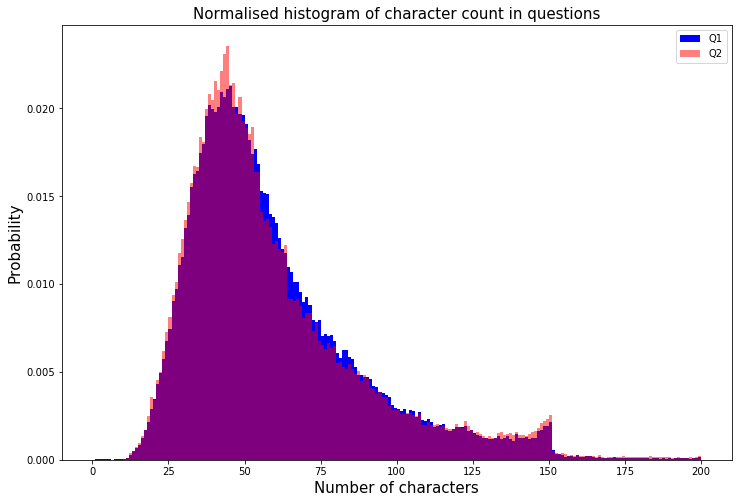

In [7]:
#Get some visual on character count
plt.figure(figsize=(12, 8))
plt.hist(train_data['q1chrlen'], bins=200, range=[0, 200], color='blue', normed=True, label='Q1')
plt.hist(train_data['q2chrlen'], bins=200, range=[0, 200], color='red',alpha = 0.5, normed=True, label='Q2')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Looks like most questions have about 40-50 characters in them.

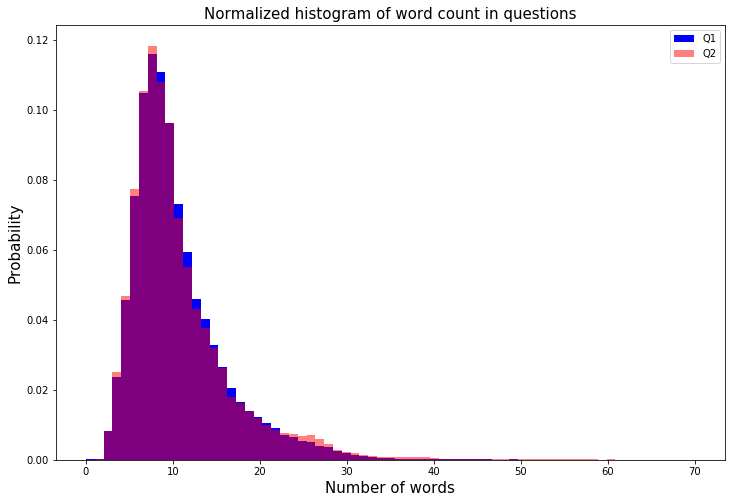

In [8]:
#Get some visual on word count
plt.figure(figsize=(12, 8))
plt.hist(train_data['q1_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='blue', label='Q1')
plt.hist(train_data['q2_nword'], bins=np.linspace(0, 70, 70), range=[0, 70], normed = True, color='red',alpha = 0.5, label='Q2')
plt.title('Normalized histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Looks like most questions have about 10 words in them.

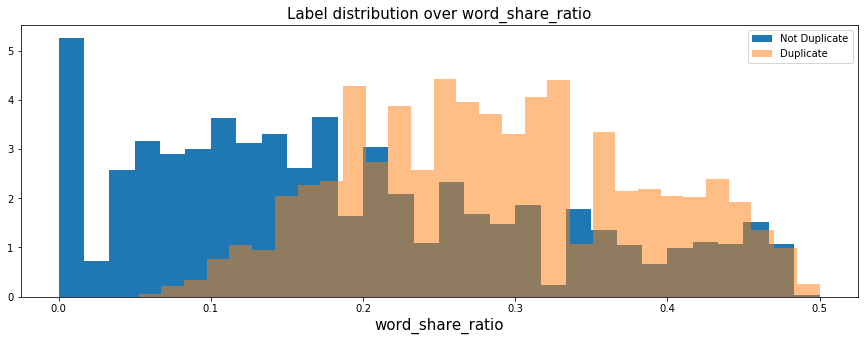

In [9]:
#Get some visual on word share
plt.figure(figsize=(15, 5))
train_word_share = train_data['word_share']
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 0], bins=30, normed=True, label='Not Duplicate')
plt.hist(train_word_share[train_data_raw['is_duplicate'] == 1], bins=30, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_share_ratio', fontsize=15)
plt.xlabel('word_share_ratio', fontsize=15)

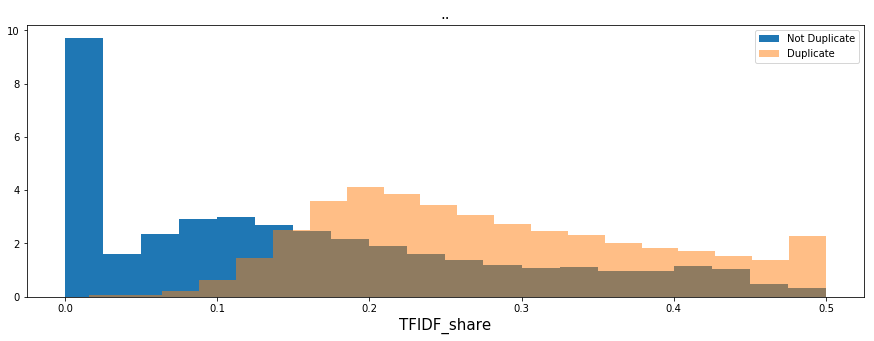

In [12]:
#Get some visual on TFIDF word share
plt.figure(figsize=(15, 5))
train_tfidf = train_data['TFIDF_share'].fillna(0)
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_tfidf[train_data_raw['is_duplicate'] == 1], bins=20, normed=True, alpha=0.5, label='Duplicate')
plt.legend()
plt.title('..', fontsize=15)
plt.xlabel('TFIDF_share', fontsize=15)

As one would expect, the word share ratio is higher for duplicate question pairs.

Now we normalized all features for better machine learning accuracy.

In [19]:
#Normalized feature values
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

In [20]:
#Split training data to train and validation data sets
label = train_data_raw['is_duplicate']
X_train, X_valid, y_train, y_valid = train_test_split(train_data, label, test_size=0.2, random_state=10)
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(train_data_scaled, label, test_size=0.2, random_state=10)

### IV. Benchmark Model

We use Random Forest as my benchmark model here. Later on I'll try to beat the benchmark accuracy.

In [15]:
#Benchmark model : random forest
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train_scaled,y_train)
prediction = rfc.predict_proba(X_valid_scaled)
pre = rfc.predict(X_valid_scaled)
score_rfc = rfc.score(X_valid_scaled, y_valid)
print "Random Forest (Benchmark model) has accuracy: %.3f" %score_rfc

Random Forest (Benchmark model) has accuracy: 0.721


In [16]:
#Test submission for Kaggle competition
prediction = rfc.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('rfc_submission.csv', index=False)

Kaggle leaderboard score : 0.55

### V. Compare Supervised Learning Models
#### 1 - Logistic Regression

In [17]:
#Model 1: Logistic regression model
#Use GridSearch cross validation to find best parameter
lr = LogisticRegression(random_state=10)
grid = {
    'C': [1e-6, 1e-3, 1e0, 1e3, 1e6],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(lr, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
score_lr = cv.best_estimator_.score(X_valid_scaled, y_valid)
print "Logistic regression model accuracy: %.3f" %score_lr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   22.0s finished


{'penalty': 'l2', 'C': 1000.0}
Logistic regression model accuracy: 0.669


In [18]:
#Test submission for Kaggle competition
lr = LogisticRegression(C = 1000, penalty = 'l2', random_state=10)
lr.fit(X_train_scaled, y_train)
prediction = lr.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('lr_submission.csv', index=False)

Kaggle leaderboard score: 0.61

#### 2 - Decision Tree

In [20]:
#Model 2: Decision tree 
dt = DecisionTreeClassifier(max_depth = 100, random_state=10)
dt.fit(X_train_scaled, y_train)
prediction = dt.predict(X_valid_scaled)
score_dt = dt.score(X_valid_scaled, y_valid)
print "Decision tree model accuracy: %.3f" %score_dt

Decision tree model accuracy: 0.695


In [23]:
#Test submission for Kaggle competition
prediction = dt.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('dt_submission.csv', index=False)

Kaggle leaderboard score: 13.44

Because decision tree prediction is not really a probability, the testing score is pretty low.

#### 3 - Support Vector Machine

In [29]:
#Model 3: SVM model
#Use GridSearch cross validation to find best parameter
svm = SVC(random_state=0, max_iter=500, probability=True)
grid = {
    'C': [1e-3, 1e0, 1e3],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
cv = GridSearchCV(svm, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
score_svm = cv.best_estimator_.score(X_valid_scaled, y_valid)
print "SVM model accuracy: %.3f" %score_svm

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 32.2min finished


{'kernel': 'sigmoid', 'C': 0.001}
SVM model accuracy: 0.492


In [31]:
#Test submission for Kaggle competition
svm = SVC(random_state=0, max_iter=1000, probability=True, kernel='sigmoid', C=0.001)
svm.fit(X_train_scaled, y_train)
prediction = svm.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('svm_submission.csv', index=False)

Kaggle leaderboard score: 0.57

#### 4 - K Nearest Neighbors 

In [32]:
#Model 4: K Nearest Neighbors
#Use grid search for best parameter
knn = KNeighborsClassifier()
grid = {
    'n_neighbors': list(range(2, 10, 2)),
    'weights': ['uniform', 'distance']
}
cv = GridSearchCV(knn, grid, scoring='neg_log_loss', verbose = True)
cv.fit(X_train_scaled, y_train)
print cv.best_params_
score_knn = cv.best_estimator_.score(X_valid_scaled, y_valid)
print "K Nearest Neighbor model accuracy: %.3f" %score_knn

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  5.0min finished


{'n_neighbors': 8, 'weights': 'uniform'}
K Nearest Neighbor model accuracy: 0.719


In [33]:
#Test submission for Kaggle competition
knn = KNeighborsClassifier(n_neighbors = 8, weights = 'uniform')
knn.fit(X_train_scaled, y_train)
prediction = knn.predict_proba(test_data_scaled)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('knn_submission.csv', index=False)

Kaggle leaderboard score: 1.64

#### 5 - Multinomial Naive Bayes 

In [35]:
#Model 5: Naive Bayes model
mnb = MultinomialNB().fit(X_train, y_train)
score_nb = mnb.score(X_valid,y_valid)
print "Naive Bayes model accuracy: %.3f" %score_nb 

Naive Bayes model accuracy: 0.633


In [36]:
#Test submission for Kaggle competition
prediction = mnb.predict_proba(test_data)
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': prediction[:,1]})
sub.to_csv('nb_submission.csv', index=False)

Kaggle leaderboard score: 0.53

#### 6 - XGBoost

In [21]:
#Model 6: XGBoost 
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_scaled, label=y_train)
d_valid = xgb.DMatrix(X_valid_scaled, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)
d_test = xgb.DMatrix(test_data_scaled)
p_test = bst.predict(d_test)

[0]	train-logloss:0.686721	valid-logloss:0.686709
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.634151	valid-logloss:0.63404
[20]	train-logloss:0.596905	valid-logloss:0.596762
[30]	train-logloss:0.569502	valid-logloss:0.569371
[40]	train-logloss:0.548966	valid-logloss:0.548845
[50]	train-logloss:0.533259	valid-logloss:0.533152
[60]	train-logloss:0.521116	valid-logloss:0.521021
[70]	train-logloss:0.511607	valid-logloss:0.511529
[80]	train-logloss:0.504034	valid-logloss:0.503967
[90]	train-logloss:0.498007	valid-logloss:0.497969
[100]	train-logloss:0.493212	valid-logloss:0.493196
[110]	train-logloss:0.489284	valid-logloss:0.489313
[120]	train-logloss:0.486026	valid-logloss:0.486087
[130]	train-logloss:0.483387	valid-logloss:0.483496
[140]	train-logloss:0.481188	valid-logloss:0.481337
[150]	train-logloss:0.479309	valid-logloss:0.479499
[160]	train-logloss:0.477704	

In [40]:
#Test submission for Kaggle competition
sub = pd.DataFrame({'test_id': test_data_raw['test_id'], 'is_duplicate': p_test})
sub.to_csv('xgb_submission.csv', index=False)

Kaggle leaderboard score: 0.39

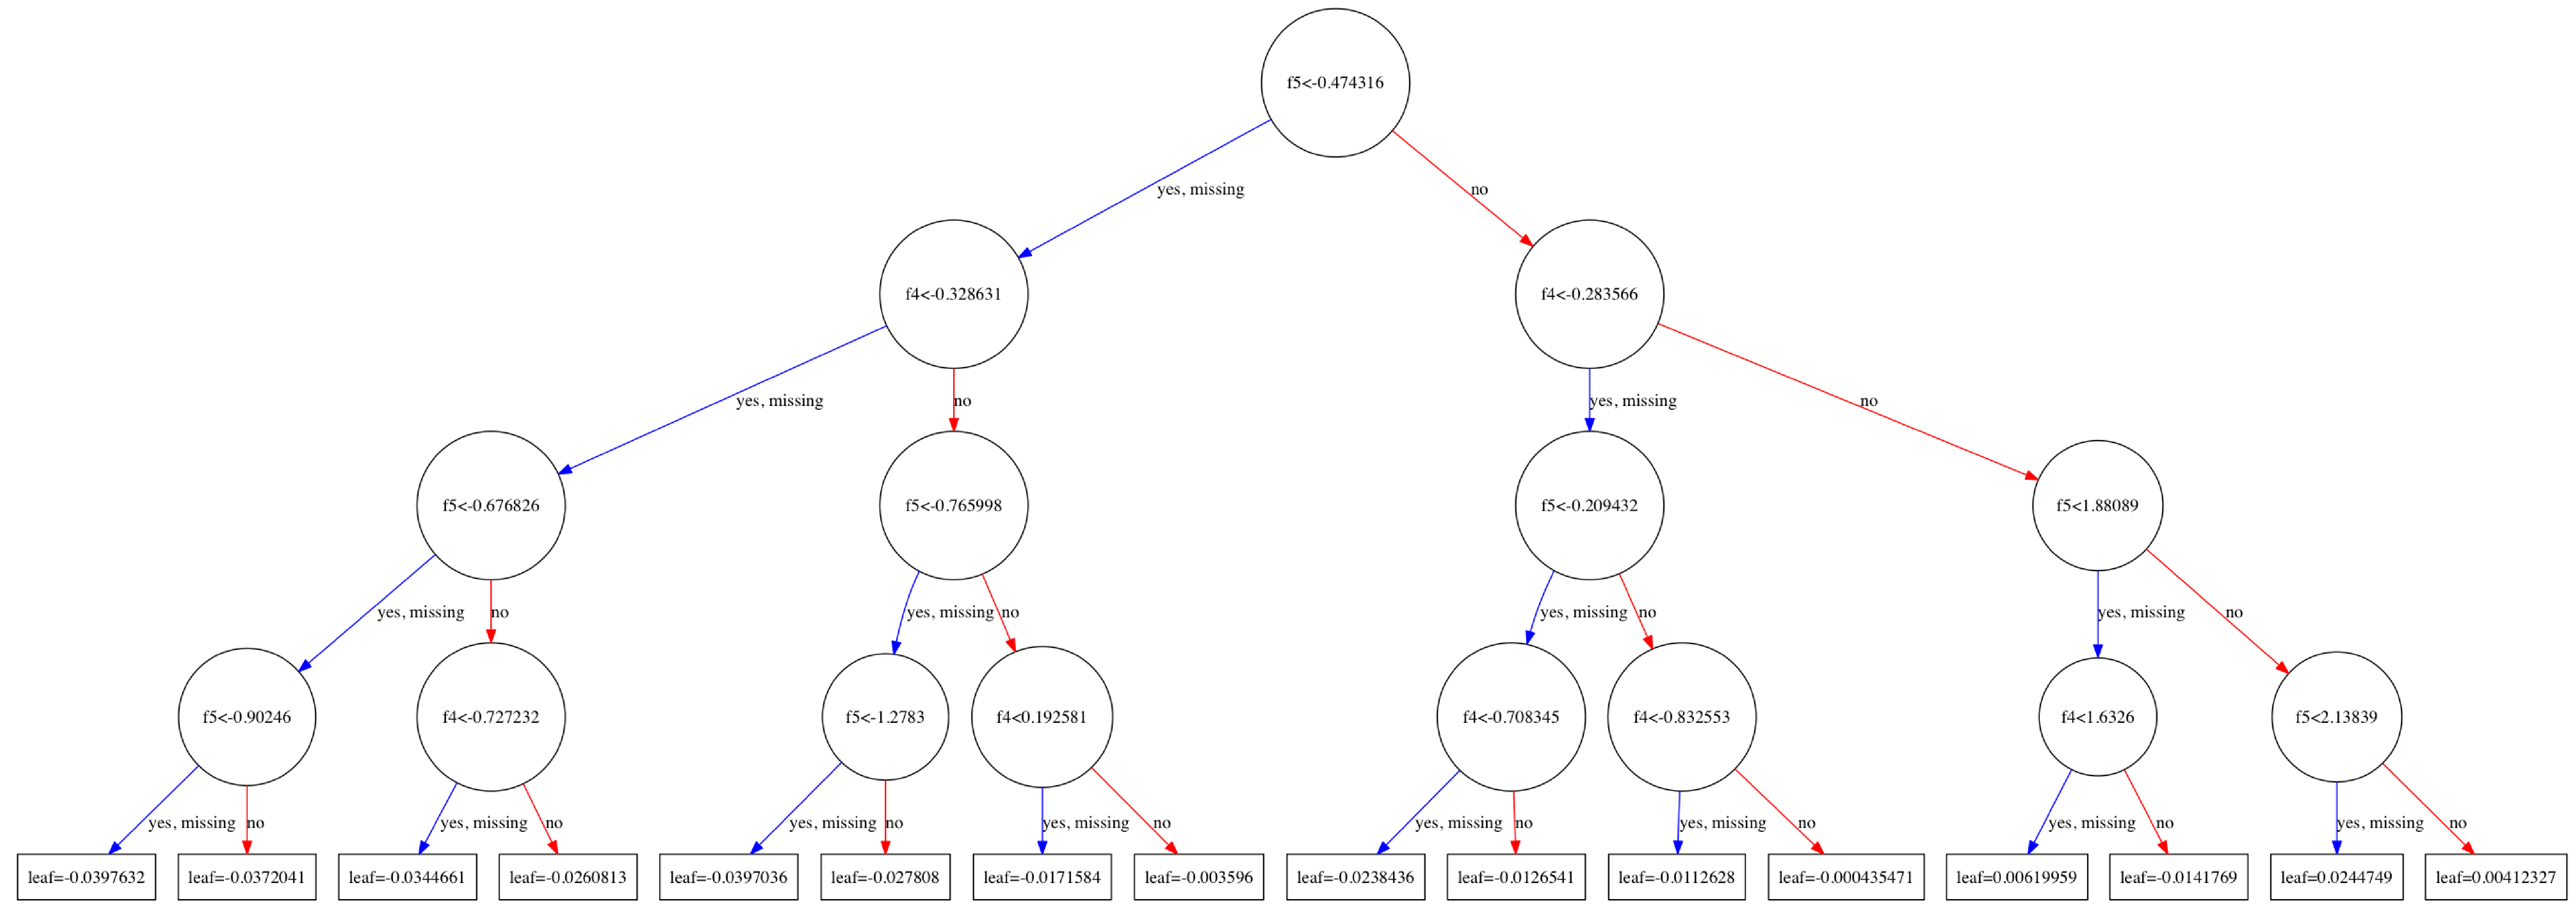

In [69]:
#Visualize the prediction
from matplotlib.pylab import rcParams
from xgboost import plot_tree
rcParams['figure.figsize'] = 120,100
plot_tree(bst)

### VI. Refinement

So far, XGboost gets the best leaderboard score, with log-loss 0.39. Let's see if I can improve it by adding more features from TFIDF vectors other than just word match share. Below I'm going to add TFIDF vectors using Sklearn TFIDFVectorize library and extract feature vectors. Due to the limitation of memory on my laptop, I'm going to set max_feature to 10k. Then I will do SVD reductions to get around 20 features. 

In [42]:
#If processd tfidf vectors already exist, import it here and skip the following code cell. 
if path.isfile('tfidf_vec.pkl'):
    tfidf_vec = pd.read_pickle('tfidf_vec.pkl')

In [21]:
#If this is not your first time running notebook, skill this step.
#Let's get TFIDF vector from each question 

Test_num = len(test_data_raw)
test_data_raw['qid1'] = pd.Series(range(2*Test_num)[1::2])
test_data_raw['qid2'] = pd.Series(range(2*Test_num+1)[2::2])
train_q1, train_q2 = train_data_raw[['qid1', 'question1']], train_data_raw[['qid2', 'question2']]
train_q1.columns = ['qid1', 'question']
train_q2.columns = ['qid2', 'question']
trainq = pd.concat((train_q1, train_q2), axis=0, ignore_index=True).fillna("")

test_q1, test_q2 = test_data_raw[['qid1', 'question1']], test_data_raw[['qid2', 'question2']]
test_q1.columns = ['qid1', 'question']
test_q2.columns = ['qid2', 'question']
testq = pd.concat((test_q1, test_q2), axis=0, ignore_index=True).fillna("")

#Combine train and test questions for our corpus
questionpairs = pd.concat((trainq,testq),axis=0, ignore_index=True).fillna("")

#Set up TFIDF Vectorizer with max 10k features then fit our question corpus
tfidfv = TfidfVectorizer(max_features = 10000)
matrixq = tfidfv.fit_transform(questionpairs['question'].values)

#Use Truncated SVD for dimension reduction on the TFIDF matrix
tsvd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10, random_state=0)
tfidf_vec = tsvd.fit_transform(matrixq)
tfidf_vec = pd.DataFrame(tfidf_vec)

#Save processed tfidf vectors for later use
tfidf_vec.to_pickle('tfidf_vec.pkl')

In [44]:
#Get length from train and test data
Train_num = len(train_data_raw)
Test_num = len(test_data_raw)

#Now separate training and testing data sets
vec_train = tfidf_vec[0:Train_num*2].reset_index(drop=True)
vec_test = tfidf_vec[Train_num*2:].reset_index(drop=True)

#### Method 1: Calculate the "distance" bewteen question 1 and question 2 TFIDF vectors

In [45]:
#Calculate the "distance" between question1 and question2 using TFIDF vectors
q2 = vec_train[Train_num:].reset_index(drop=True)
q1 = vec_train[0:Train_num]
tfidfvec_train = np.abs(q1-q2)

q2t = vec_test[Test_num:].reset_index(drop=True)
q1t = vec_test[0:Test_num]
tfidfvec_test = np.abs(q1t-q2t)

In [50]:
#Add these TFIDF reduced vector "distance" as new features
label = train_data_raw['is_duplicate']
train_data_new = pd.concat((train_data, tfidfvec_train), axis=1)
test_data_new = pd.concat((test_data, tfidfvec_test), axis=1)

#Split train and valid data sets
X_train, X_valid, y_train, y_valid = train_test_split(train_data_new, label, test_size=0.2, random_state=10)
X_train['q2chrlen'] = np.nan_to_num(X_train['q2chrlen'])

#Normalize data
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
#Use Benchmark model to see if accuracy improves
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train_scaled,y_train)
prediction = rfc.predict_proba(X_valid_scaled)
score_rfc = rfc.score(X_valid_scaled, y_valid)
print "Random Forest (Benchmark model) has accuracy: %.3f" %score_rfc

Random Forest (Benchmark model) has accuracy: 0.722


It seems like adding all the TFIDF vector difference as new features doesn't improve accuracy by much. The reason might be I already accounted for this word-vec factor in my "TFIDF word share" features.

#### Method 2: All all TFIDF vectors from question 1 and question 2 into feature columns

In [52]:
#Separate q1 and q2 vectors and concatenate them 
q2 = vec_train[Train_num:].reset_index(drop=True)
q1 = vec_train[0:Train_num]
tfidfvec_train = pd.concat((q1,q2),axis = 1, ignore_index=True)

q2t = vec_test[Test_num:].reset_index(drop=True)
q1t = vec_test[0:Test_num]
tfidfvec_test = pd.concat((q1t,q2t),axis = 1, ignore_index=True)

In [54]:
#Add these TFIDF reduced vector "distance" as new features
label = train_data_raw['is_duplicate']
train_data_new2 = pd.concat((train_data, tfidfvec_train), axis=1)
test_data_new2 = pd.concat((test_data, tfidfvec_test), axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(train_data_new2, label, test_size=0.2, random_state=10)
X_train.loc[:,'q2chrlen'] = np.nan_to_num(X_train.loc[:,'q2chrlen'])

#Normalize data
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

In [55]:
#Benchmark model : random forest second try
rfc = RandomForestClassifier(max_depth=5, random_state=0)
rfc.fit(X_train_scaled,y_train)
prediction = rfc.predict_proba(X_valid_scaled)
score_rfc = rfc.score(X_valid_scaled, y_valid)
print "Random Forest (Benchmark model) has accuracy: %.3f" %score_rfc

Random Forest (Benchmark model) has accuracy: 0.708


The accuracy is even worse with TFIDF vectors concatenate together.

#### VII. Conclusion

After trying different parameters (not showing here), the best Kaggle leaderboard score (log-loss) is 0.39 using XGboost model. It ranked top 54%. To get better ranking, I will consider clean up the iput strings such as puntuation, add more features, and run more training steps. In order to avoid overfitting by submitting too many times, one has to do data shuffling and regularization. 